## 2. Sliding Window Algorithm

In [2]:
setwd("/Users/jacobbradley/Documents/CCG/Code")

### Packages

In [3]:
install.packages("tidyverse")
library(tidyverse)
# Data Handling

if (!requireNamespace("BiocManager"))
    install.packages("BiocManager")
BiocManager::install()
library(BiocManager)
# General bioinformatics packages

library(BSgenome)
library(BSgenome.Hsapiens.UCSC.hg19)
# Human genome build GChr37


The downloaded binary packages are in
	/var/folders/g9/9x6m35fn5ydf88vdlm9n1vg80000gn/T//RtmpFg44U3/downloaded_packages


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required namespace: BiocManager
Bioconductor version 3.8 (BiocManager 1.30.3), R 3.5.1 (2018-07-02)
Update old packages: 'BiocManager', 'BiocParallel', 'circlize', 'ELMER',
  'ensembldb', 'farver', 'foreign', 'ggpubr', 'Gviz', 'haven', 'lattice',
  'MASS', 'Matrix', 'mclust', 'mgcv', 'openssl', 'RcppEigen', 'readr',
  'rtracklayer', 'survival', 'VariantAnnotation'
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterE

In [4]:
source("TMB_Funcs.txt")
# My Stuff!

### Attempt a very limited sliding window algorithm (1 Chromosome, 1 Data Set)

In [5]:
new_data <- read_tsv("/Volumes/CCG8/processed_data/brca_tcga/data_mutations_extended.txt")
genome <- BSgenome.Hsapiens.UCSC.hg19

#load a sample data set (in this case TCGA breast cancer data)
#load a reference genome to slide through

Warning message:
“Missing column names filled in: 'X54' [54]”Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Score = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  stop_WU = col_integer(),
  X54 = col_double(),
  tumor_vaf = col_double(),
  normal_ref_reads = col_integer(),
  start_WU = col_integer(),
  strand_WU = col_integer(),
  tumors_var_reads = col_integer(),
  normal_vaf = col_double(),
  tumor_ref_reads = col_integer(),
  normal_var_reads = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“3282 parsing failures.
row # A tibble: 5 x 5 col     row col     expected  actual file                                         

In [6]:
window_size <- 1000000
jump_length <- 100000

In [10]:
x <- chromosome_slide(maf_file = new_data, global_tmb_table = NULL, Chromosome = "X", window_size, jump_length)

Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

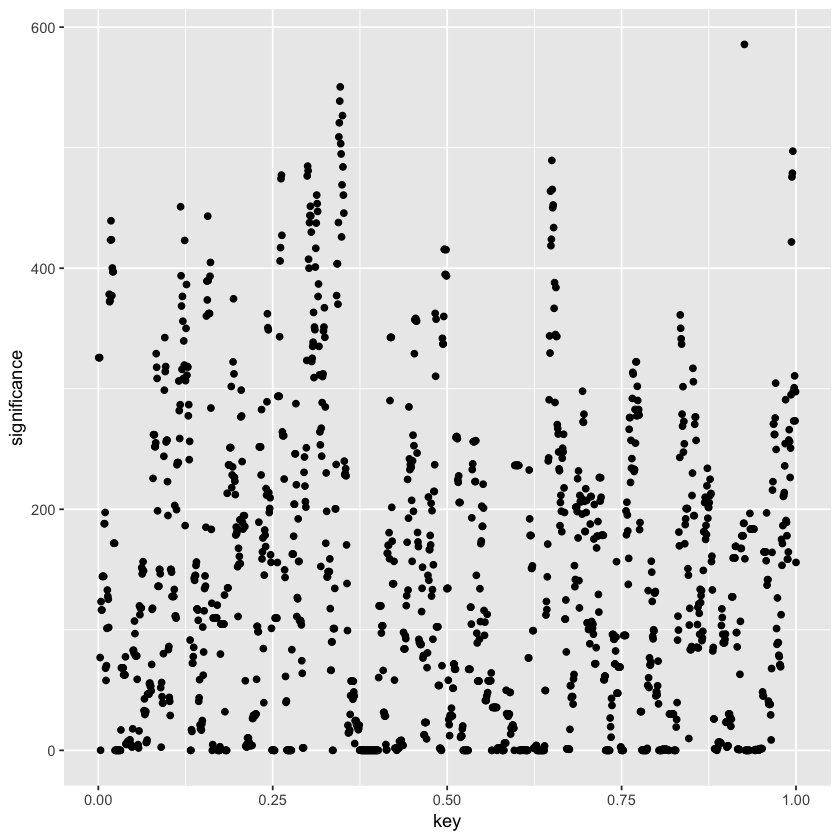

In [11]:
ggplot(x, aes(x= key, y = significance))+ geom_point()

### Do the same thing for the entire genome (1 Study)

In [185]:
window_size <- 1000000
jump_length <- 100000

genome_length <- 0
for (i in 1:24) {
    genome_length <- genome_length + length(genome[[i]])
}

In [244]:
gwas_first_run <- genome_slide(maf_file = new_data, global_tmb_table = NULL, window_size, jump_length)

In [46]:
write_tsv(path = '/Users/jacobbradley/Documents/CCG/Data/gwas_first_run', x = gwas_first_run)

#gwas_first_run <- read_tsv('/Users/jacobbradley/Documents/CCG/Data/gwas_first_run')

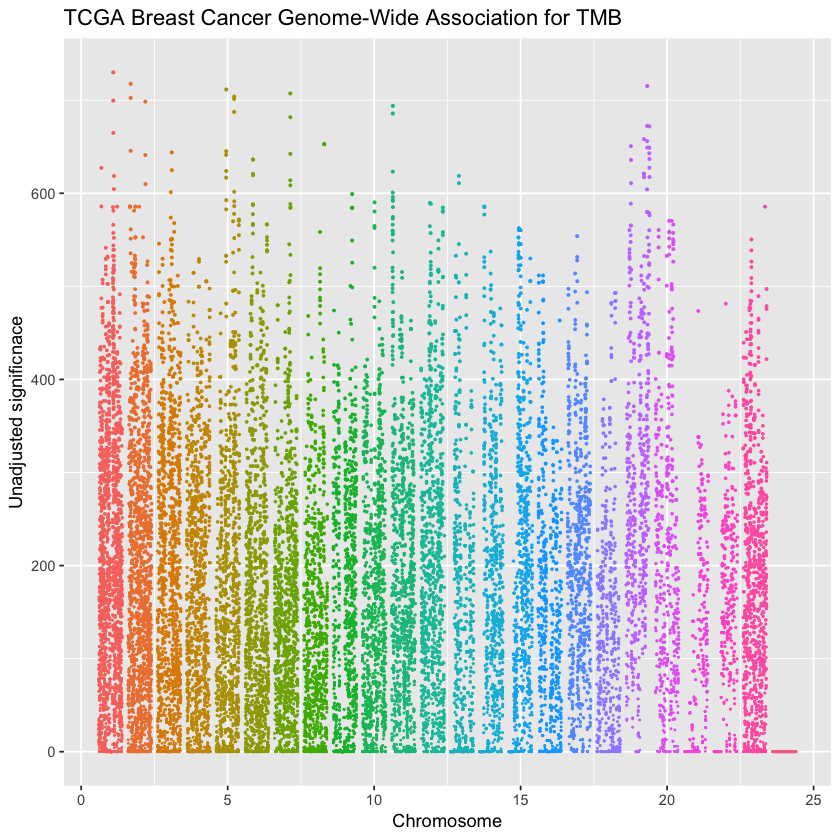

In [15]:
ggplot(gwas_first_run, aes(x = chromosome - 0.4 + 0.8*key, y = significance, colour = factor(chromosome), size = significance)) + 
    geom_point() + scale_size(range = c(0.1,0.5)) + theme(legend.position = "none") + labs(x = "Chromosome", y = "Unadjusted significnace") + 
    ggtitle("TCGA Breast Cancer Genome-Wide Association for TMB")


### Siphoning off the top 1% of positions

In [ ]:
chromosome_restricted_slide <- function(maf_file, previous_run, zoom = 10, global_tmb_table = NULL, Chromosome, ns = FALSE, coverage = 10) {

    chromosomes <- c(1:22, "X", "Y")
    maf_file <- abridge(maf_file, nonsilent = ns)
    
    old_jump_length <- previous_run[2,"position"] - previous_run[1,"position"]
    
    new_jump_length <- max(1,floor(old_jump_length/zoom))
    new_window_size <- coverage*new_jump_length
    
    chromosome_positions <- previous_run[]
    
    if (is.null(global_tmb_table)) {
        global_tmb_table <- TMB_Calc(maf_file, nonsilent = TRUE)
    }
    
    significance_vector <- c()
    position_vector <- c()
    chromosome_length <- length(genome[[which(chromosomes == Chromosome)]])
    
    
    for (position in seq(from = 1, to = chromosome_length - window_size, by = jump_length)) { 
        
        local_tmb_table <- Local_TMB_Calc(maf_file, Chrom = Chromosome, Start = position, Window_Size = window_size, pre_abridged = TRUE)
        significance_vector <- c(significance_vector, getSignificance(local_tmb_table, global_tmb_table))
        position_vector <- c(position_vector, position)
        
    
    } 
    
    len <- length(significance_vector)
    chromosome_vector <- rep(Chromosome, len)
    key_vector <- (1:len)/len
    
    return(tibble(chromosome = chromosome_vector, position = position_vector, key = key_vector, significance = significance_vector))
    
}

In [7]:
tcga_brca_hotspots <- genome_slide(maf_file = new_data, global_tmb_table = NULL, window_size, jump_length)

Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "1"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "2"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "3"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "4"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "5"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "6"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "7"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "8"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "9"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "10"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "11"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "12"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "13"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "14"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "15"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "16"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "17"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "18"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "19"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "20"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "21"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "22"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "X"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "Y"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

In [9]:
write_tsv(path = '/Users/jacobbradley/Documents/CCG/Data/tcga_brca_hotspots', x = tcga_brca_hotspots)

#tcga_brca_hotspots <- read_tsv('/Users/jacobbradley/Documents/CCG/Data/tcga_brca_hotspots')

In [11]:
nsclc_data <- read_tsv("/Volumes/CCG8/processed_data/nsclc_tcga_broad_2016/data_mutations_extended.txt", skip = 1)

Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Strand = col_integer(),
  `MA:FIS` = col_double(),
  t_depth = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_depth = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  ALLELE_NUM = col_integer(),
  DISTANCE = col_integer(),
  HGNC_ID = col_integer(),
  PICK = col_integer(),
  HGVS_OFFSET = col_integer(),
  MINIMISED = col_integer(),
  ExAC_AF = col_double(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_AMR = col_double()
  # ... with 24 more columns
)
See spec(...) for full column specifications.


In [12]:
tcga_nsclc_hotspots <- genome_slide(maf_file = nsclc_data, global_tmb_table = NULL, window_size, jump_length)

Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "1"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "2"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "3"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "4"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "5"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "6"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "7"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "8"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "9"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "10"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "11"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "12"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "13"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "14"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "15"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "16"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "17"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "18"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "19"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "20"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "21"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "22"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "X"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "Y"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

In [13]:
write_tsv(path = '/Users/jacobbradley/Documents/CCG/Data/tcga_nsclc_hotspots', x = tcga_nsclc_hotspots)

#tcga_nsclc_hotspots <- read_tsv('/Users/jacobbradley/Documents/CCG/Data/tcga_nsclc_hotspots')

In [14]:
coadread_data <- read_tsv("/Volumes/CCG8/processed_data/coadread_tcga/data_mutations_extended.txt")#, skip = 1)

Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.


In [17]:
tcga_coadread_hotspots <- genome_slide(maf_file = coadread_data, global_tmb_table = NULL, window_size, jump_length)

Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "1"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "2"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "3"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "4"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "5"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "6"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "7"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "8"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "9"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "10"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "11"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "12"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "13"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "14"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "15"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "16"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "17"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "18"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "19"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "20"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "21"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "22"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "X"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "Y"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

In [25]:
write_tsv(path = '/Users/jacobbradley/Documents/CCG/Data/tcga_coadread_hotspots', x = tcga_coadread_hotspots)

#tcga_coadread_hotspots <- read_tsv('/Users/jacobbradley/Documents/CCG/Data/tcga_coadread_hotspots')

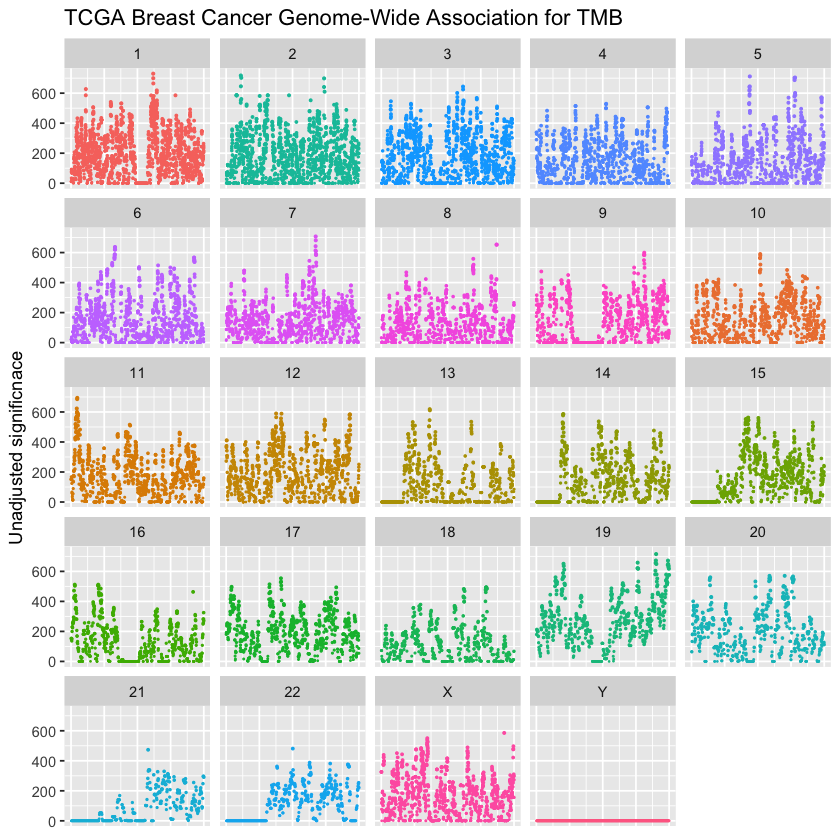

In [82]:
chromosomes <- c(1:22,"X","Y")

tcga_brca_hotspots %>%  
    #filter(significance > quantile(significance, .99)) %>% 
    ggplot(aes(x = key, y = significance, size = significance, colour = chromosome)) + 
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())+
    geom_point() + scale_size(range = c(0.1,0.5)) + theme(legend.position = "none") + labs(x = NULL, y = "Unadjusted significnace") + 
    ggtitle("TCGA Breast Cancer Genome-Wide Association for TMB") + facet_wrap(~factor(chromosome, levels = chromosomes))


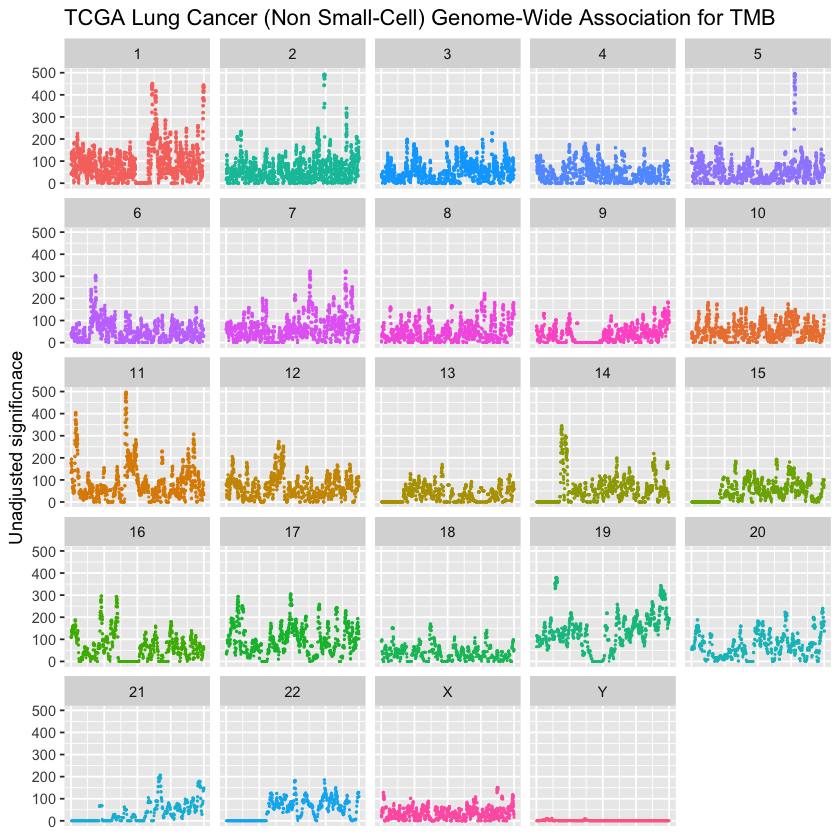

In [83]:
chromosomes <- c(1:22,"X","Y")

tcga_nsclc_hotspots %>%  
    #filter(significance > quantile(significance, .99)) %>% 
    ggplot(aes(x = key, y = significance, size = significance, colour = chromosome)) + 
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())+
    geom_point() + scale_size(range = c(0.1,0.5)) + theme(legend.position = "none") + labs(x = NULL, y = "Unadjusted significnace") + 
    ggtitle("TCGA Lung Cancer (Non Small-Cell) Genome-Wide Association for TMB") + facet_wrap(~factor(chromosome, levels = chromosomes))


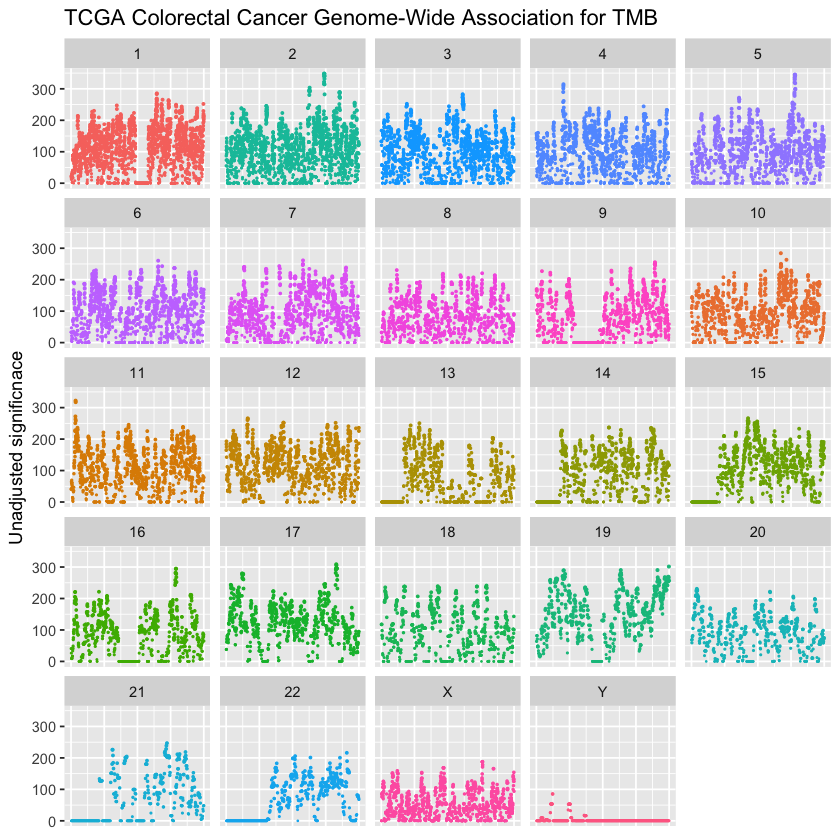

In [84]:
chromosomes <- c(1:22,"X","Y")

tcga_coadread_hotspots %>%  
    #filter(significance > quantile(significance, .99)) %>% 
    ggplot(aes(x = key, y = significance, size = significance, colour = chromosome)) + 
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())+
    geom_point() + scale_size(range = c(0.1,0.5)) + theme(legend.position = "none") + labs(x = NULL, y = "Unadjusted significnace") + 
    ggtitle("TCGA Colorectal Cancer Genome-Wide Association for TMB") + facet_wrap(~factor(chromosome, levels = chromosomes))

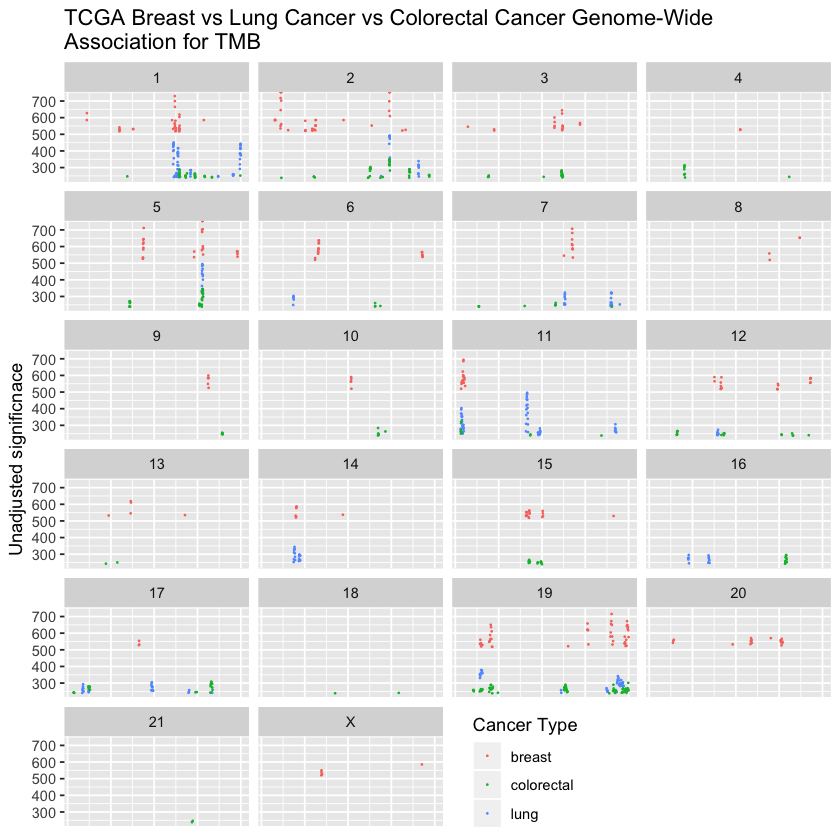

In [151]:
three_types_hotspots <- bind_rows((tcga_brca_hotspots %>% 
                                      mutate(cancer_type = "breast") %>% 
                                      filter(significance > quantile(significance, .99))),
                                 (tcga_nsclc_hotspots %>% 
                                     mutate(cancer_type = "lung") %>% 
                                     filter(significance > quantile(significance, .99))),
                                 (tcga_coadread_hotspots %>% 
                                     mutate(cancer_type = "colorectal") %>% 
                                     filter(significance > quantile(significance, .99))))

three_types_hotspots %>% 
    ggplot(aes(x = key, y = significance, colour = cancer_type)) + 
    geom_point(size = 0.1) + scale_size(range = c(0.1,0.5)) + theme(legend.position = c(0.6,0.075)) + 
    labs(x = NULL, y = "Unadjusted significnace") + scale_colour_discrete(name="Cancer Type") +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())+
    ggtitle("TCGA Breast vs Lung Cancer vs Colorectal Cancer Genome-Wide\nAssociation for TMB") + facet_wrap(~factor(chromosome, levels = chromosomes), ncol = 4)
    

In [123]:
venn_values <- three_types_hotspots %>% 
    spread(key = cancer_type, value = significance) %>% 
    group_by(chromosome, position) %>% 
    summarise(b   = !is.na(breast) &  is.na(lung) &  is.na(colorectal), 
              l   =  is.na(breast) & !is.na(lung) &  is.na(colorectal), 
              c   =  is.na(breast) &  is.na(lung) & !is.na(colorectal),
              bl  = !is.na(breast) & !is.na(lung) &  is.na(colorectal),
              bc  = !is.na(breast) &  is.na(lung) & !is.na(colorectal),
              lc  =  is.na(breast) & !is.na(lung) & !is.na(colorectal),
              blc = !is.na(breast) & !is.na(lung) & !is.na(colorectal)) %>% 
    ungroup() %>% 
    select(3:9) %>% 
    colSums()

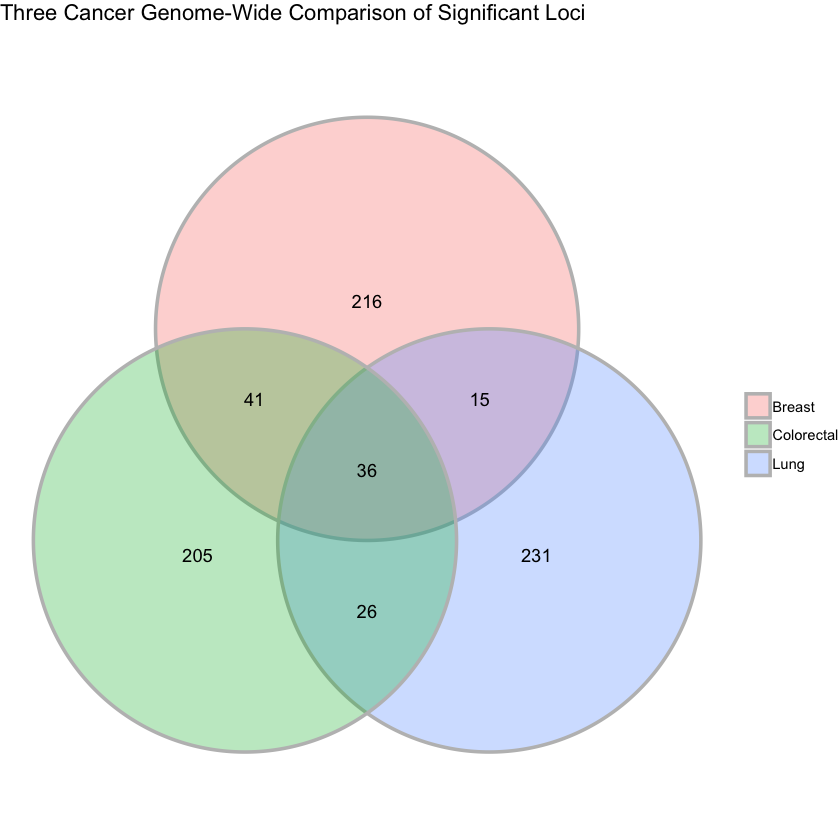

In [161]:
require(ggforce)

venn_data <- tibble(values = venn_values, x = c(0, 1.2, -1.2, 0.8, -0.8, 0, 0),
         y = c(1.2, -0.6, -0.6, 0.5, 0.5, -1, 0))

df.venn <- data.frame(x = c(0, 0.866, -0.866),
                      y = c(1, -0.5, -0.5),
                      cancer_types = c('Breast', 'Lung', 'Colorectal'))
    
ggplot(df.venn, aes(x0 = x, y0 = y, r = 1.5, fill = cancer_types)) + 
    labs(title = "Three Cancer Genome-Wide Comparison of Significant Loci") +
    geom_circle(alpha = .3, size = 1, colour = 'grey') +
    coord_fixed() + theme_void() + theme(legend.title = element_blank(), plot.title = element_text(vjust = 15)) + 
    annotate("text", x = venn_data$x, y = venn_data$y, label = venn_data$values)

In [169]:
tcga_brca_hotspots_ns <- genome_slide(maf_file = new_data, global_tmb_table = NULL, window_size, jump_length, ns = TRUE)
tcga_nsclc_hotspots_ns <- genome_slide(maf_file = nsclc_data, global_tmb_table = NULL, window_size, jump_length, ns = TRUE)
tcga_coadread_hotspots_ns <- genome_slide(maf_file = coadread_data, global_tmb_table = NULL, window_size, jump_length, ns = TRUE)

write_tsv(path = '/Users/jacobbradley/Documents/CCG/Data/tcga_brca_hotspots_ns', x = tcga_brca_hotspots_ns)
write_tsv(path = '/Users/jacobbradley/Documents/CCG/Data/tcga_nsclc_hotspots_ns', x = tcga_nsclc_hotspots_ns)
write_tsv(path = '/Users/jacobbradley/Documents/CCG/Data/tcga_coadread_hotspots_ns', x = tcga_coadread_hotspots_ns)

Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "1"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "2"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "3"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "4"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "5"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "6"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "7"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "8"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "9"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "10"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "11"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "12"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "13"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "14"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "15"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "16"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "17"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "18"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "19"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "20"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "21"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "22"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "X"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "Y"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "1"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "2"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "3"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "4"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "5"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "6"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "7"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "8"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "9"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "10"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "11"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "12"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "13"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "14"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "15"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "16"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "17"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "18"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "19"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "20"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "21"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "22"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "X"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "Y"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "1"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "2"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "3"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "4"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "5"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "6"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "7"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "8"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "9"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "10"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "11"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "12"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "13"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "14"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "15"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "16"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "17"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "18"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "19"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "20"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "21"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "22"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "X"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "Y"


Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”